# Projet Photos - Création des statistiques

Récupération des données de la base mongodb

- Mise sous dataframe

- Statistiques

- Visualisations


## Avancement

### Réalisé

- affichage données début

- récupération des données mongodb dans un dataframe (par découpage possible)

### A venir

- Calcul et présentation des statistiques suivantes

    - Nombre de fichiers + volume (cumul des tailles) par : 
    
        .année
        
        .mois
        
        .jour
        
        .catégorie de fichier (image, vidéo)
        
        .type de fichier
        
        .répertoire initial
        
        
    NB : il faut pouvoir croiser les résultats
        
        
        
        
        
        
        

# Import

In [12]:
import os
import datetime as dt
from datetime import datetime
import pandas as pd

#Pour mongodb
import pymongo


# Fonctions

### A mettre en module ?

In [15]:
#Fonction de calcul du nombre et de la taille totale des fichiers catalgués dans la base

# ! CETTE FONCTION EST UNE COPIE DE CELLE PRESENTE DANS CATALOGUE -

def fnph_clc_nb_st_size_tot(parm_collection):
    """
    Fonction de calcul du nombre et de la taille totale des fichiers catalgués dans la base
    retourne une liste de deux éléments : taille, nombre
    """
    #Requête aggrégation
    totalSize = parm_collection.aggregate(
       [
         {
           "$group":
             {
               "_id"        : "",
               "totalSize"  : { "$sum": "$stats.st_size" },
               "count"      : { "$sum": 1 }
             }
         }
       ]
    )

    
    reslist=list(totalSize)[0]
    result=[reslist['totalSize'], reslist['count']]
    return(result)

### Nouvelles fonctions

In [378]:
#JE GARDE CETTE SOLUTION - A VOIR ENSUITE COMMENT L'UTILISER (choix de la taille du chunk)
def fnph_read_mongodb(
           parm_db, 
           parm_collection, parm_query={}, 
           parm_host='localhost', parm_port=27017, 
           parm_username=None, parm_password=None,
           parm_chunksize = 100, parm_no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db=mydb_name)
    
    client = MongoClient(host=parm_host, port=parm_port)
    # Make a query to the specific DB and Collection
    db_aux = client[parm_db]

    # Some variables to create the chunks
    nb_enr = db_aux[parm_collection].find(parm_query).count()
    skips_variable = range(0, nb_enr, int(parm_chunksize))
    
    if len(skips_variable)<=1: #en fait il ne peut être qu'égal à 1 au minimum ou à 0 si la base est vide
        skips_variable = [0,nb_enr]

    # Iteration to create the dataframe in chunks.
    for i in range(1,len(skips_variable)):
        # Expand the cursor and construct the DataFrame
        df_aux =pd.DataFrame(list(db_aux[parm_collection].find(parm_query)[skips_variable[i-1]:skips_variable[i]]))

        if parm_no_id:
            del df_aux['_id']

        # Concatenate the chunks into a unique df
        if 'df' not in locals():
            df =  df_aux
        else:
            df = pd.concat([df, df_aux], ignore_index=True)
            
    deb=(len(skips_variable)-1)*parm_chunksize
    fin=nb_enr
    df_aux =pd.DataFrame(list(db_aux[parm_collection].find(parm_query)[deb:fin]))
    if 'df' not in locals():
        df =  df_aux
    else:
        df = pd.concat([df, df_aux], ignore_index=True)
    

    return df

# Traitement principal

In [376]:
%%time
#Programme principal

#----------------------------------------------------------------------------------------------------------
#description :

# Préparation
# - Accès à la bd mongdodb
# - Récupération des données dans un df (par découpage pour gérer vitesse vs utilisation mémoire)

# Obtention des statistiques

# Présentation des statistiques
#----------------------------------------------------------------------------------------------------------


#Paramètres utilisateurs***********************************************************************************
#Paramètres utilisateurs***********************************************************************************
#Paramètres utilisateurs***********************************************************************************
#Libellé traitement 1<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
montitre_traitement="Stats - Premier traitement"

#Répertoire de sauvegarde de l'historique du traitement
parm_df_log_rep = r'C:\Users\LENOVO\Documents\Projets\Prj_photos\Prjph_log'

#Paramètres de connexion
#------ Base  -------------------*
#connection au serveur mongodb 27017, base test
client = pymongo.MongoClient('localhost',27017)
mydb = client["prjph_catalogue"]
mydb_name = "prjph_catalogue"
mycollection_name = "test_documents"        #TEST
#mycollection_name = "images_videos"          #PREPROD
#------ ---------- -------------------*
mycollection = mydb[mycollection_name]
#-------------------------------------*

#----------------
#DEBUT TRAITEMENT
#----------------

#----------------
#initialisations
#----------------

#Compteurs

#init le df historique des répertoires traités
df_log=pd.DataFrame(columns=['unique_id','time','rep_explored','nb_sous_rep', 'nb_of_files', 'nb_of_files_cumul', 'comment'])          #df contenant la liste des répertoires traités


#global_unique_id : Variable de valeur unique pour rsgner unique_id lors des différents appels
strtimestamp = str(datetime.timestamp(datetime.now()))
global_unique_id = strtimestamp
print('\n           global_unique_id:', global_unique_id,'\n')

#------------
# TRAITEMENT
#------------
start_time=datetime.now()
print('start..................... : ', start_time, '\n')

print("\n**** Collection            :", mycollection_name, "****\n")
print("****")
print("****")
print("****")
print("****")
print("****")

#Volume de la base : 
print(fnph_clc_nb_st_size_tot(mycollection))

#Stockage en dataframe
df_data = read_mongo2(mydb_name, mycollection_name, parm_chunksize=mychunksize, parm_no_id=False)

    
#ajout de la ligne start dans df_log 
#rmq : nb_sous_rep et nb_of_files sont les documents à la racine du répertoire, pas le total
df_log=df_log.append({'unique_id'   :global_unique_id,
                      'time'        :str(datetime.now()),
                      'rep_explored':" <--- début de traitement - <"+montitre_traitement+">-->",
                      'comment'     :"start "}, ignore_index=True)


# --------------------
# FIN DE TRAITEMENT
# --------------------

#-----------------------------------------------------------------------------
msg    = ['']*12
end_time=datetime.now()
msg[0] = '\ndone----------------------------------------'
msg[1] = 'df_data.shape=' + str(df_data.shape)
msg[2] = ''
msg[3] = ''
msg[4] = ''
#msg[5] = 'taille ttle des fichiers en base  : ' + str(var_tailletot)
#msg[6] = 'nombre ttl de  documents en base  : ' + str(var_nbtot)
msg[7] = 'Durée du traitement               : ' + str(end_time - start_time)
msg[8] = ''
msg[9] = ''
msg[10] = 'done----------------------------------------'
for i in range(len(msg)):
    if msg[i]!='':
        print(msg[i])

#Stockage de la fin de traitement dans l'historique df_log.
for i in range(len(msg)):
    if msg[i]!="":
        df_log=df_log.append({'unique_id'   : global_unique_id,
                              'time'        : str(end_time),
                              'comment'     : msg[i]}, ignore_index=True)

#Sauvegarde du df_log - nom complété de la collection et nom du répertoire exploré
dnow = datetime.now()
strtimestamp = str(datetime.timestamp(dnow)).replace('.','_')
mypathlog=r'C:\Users\LENOVO\Documents\Projets\Prj_photos\Prjph_log'

df_log_filename= 'prjph_df_log_stats__' +                                   \
                    global_unique_id.replace('.','_') + "__" +        \
                    mycollection_name + "__" +                        \
                 '.csv' #référencement avec global_unique_id utilisé pour référencer les documents dans la base.
df_log.to_csv(os.path.join(mypathlog,df_log_filename), sep='\t')
print(df_log_filename, 'saved into', mypathlog)

print('\nended..................... : ', end_time, '\n')

#Programme principal fin




           global_unique_id: 1603145475.172059 

start..................... :  2020-10-20 00:11:15.173055 


**** Collection            : images_videos ****

****
****
****
****
****
[178924637297, 72360]


<ipython-input-338-09b3dbfb1a13>:24: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  nb_enr = db_aux[parm_collection].find(parm_query).count()



done----------------------------------------
df_data.shape=(72360, 10)
Durée du traitement               : 0:00:06.203483
done----------------------------------------
prjph_df_log_stats__1603145475_172059__images_videos__.csv saved into C:\Users\LENOVO\Documents\Projets\Prj_photos\Prjph_log

ended..................... :  2020-10-20 00:11:21.376538 

Wall time: 6.25 s


# Tests

In [394]:
%%time
#Test de fnph_read_mongodb avec graphique pour évaluer la bonne taille des 'chunks'
df_graph=pd.DataFrame(columns=['date','size','timelaps'])

#variables de test
tot_enr = mydb[mycollection_name].find({}).count()
mysize  = 5000

#Traitement
mydate=datetime.now()
for i_size in list(range(0,tot_enr,mysize))[1:]:
    mychunksize=i_size
    start=datetime.now()
    #dftest4 = read_mongo2(mydb_name, mycollection_name, parm_chunksize=mychunksize, parm_no_id=False)
    dftest4 = fnph_read_mongodb(mydb_name, mycollection_name, parm_chunksize=mychunksize, parm_no_id=False)
    end  = datetime.now()
    timelaps=end-start
    print(i_size, timelaps)
    df_graph = df_graph.append({ 'date':mydate, 'size':i_size, 'timelaps': timelaps}, ignore_index=True) 
    dftest4.shape
    
df_graph.shape, tot_enr

<timed exec>:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
<ipython-input-378-ac461cf54111>:18: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  nb_enr = db_aux[parm_collection].find(parm_query).count()


5000 0:00:06.765017
10000 0:00:04.181642
15000 0:00:05.566068
20000 0:00:05.795069
25000 0:00:05.426207
30000 0:00:05.089753
35000 0:00:03.520802
40000 0:00:04.762869
45000 0:00:04.824393
50000 0:00:04.911214
55000 0:00:03.573816
60000 0:00:05.133340
65000 0:00:04.894628
70000 0:00:04.827343
Wall time: 1min 9s


(14, 3)

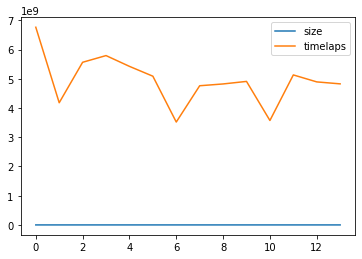

In [395]:
df_graph.iloc[:,1:].plot()

stamp = str(datetime.timestamp(dnow)).replace('.','_')

df_graph_filename= 'prjph_df_graph__' +                                   \
                    mycollection_name + "__" +                        \
                    stamp + \
                   '.csv'
df_graph_filename
df_graph.to_csv(os.path.join(mypathlog,df_graph_filename), sep='\t')
